# Here we compare the Results of ChatGPT against the manuell Results

In [33]:
import pandas as pd
import numpy as np
import os, json, re
from support_functions.load_data import load_datasets_with_annotations as loading
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from openpyxl import load_workbook, Workbook
from openpyxl.styles import Font, Alignment
from openpyxl.worksheet.worksheet import Worksheet
from openpyxl.utils import get_column_letter as utils_get_column_letter

### Loading the data from excel data

In [34]:
def load_datasets_add_line() -> dict[str, list]:
    datasets: dict[str, list] = loading()
    for key in datasets.keys():
        current_dataset = datasets[key]
        for i, item in enumerate(current_dataset, start=1):
            item = {'counter': i, **item}
            current_dataset[i-1] = item
    return datasets

In [35]:
def prepaire_excel_data() -> pd:
    current_directory = os.getcwd()
    suffix = '\\redundanciesbyannotations'
    directory_excel = current_directory[:-len(suffix)] if current_directory.endswith(suffix) else current_directory
    directory_excel += "\\Dataset\\Evaluation_v4.xlsx"
    excel_data = pd.read_excel(directory_excel, usecols=lambda column: 'Item' not in column, skiprows=range(1), sheet_name="Ground Truth")
    excel_data = excel_data.drop(columns=['Unnamed: 0', 'Unnamed: 12', 'total', 'main', 'benefit', 'total.1', 'main.1', 'benefit.1'], axis=1)
    excel_data = excel_data.rename(columns={'Main Part \nPartial': 'Main Part Partial', 'Main Part \nFull': 'Main Part Full', 'Benefit\nPartial':'Benefit Partial','Benefit\nFull':'Benefit Full'})
    excel_data.index += 1
    excel_data = excel_data.fillna("Empty")
    
    ## Map line number to user story number
    excel_data.insert(loc=4, column='Corresponding USID 1', value=0)
    excel_data.insert(loc=5, column='Corresponding USID 2', value=0)
    datasets = load_datasets_add_line()
    for idx in range(len(excel_data)):
        redundant_pairs = excel_data.iat[idx, 1]
        parts = redundant_pairs.split('_')
        first_number = int(parts[2])
        second_number = int(parts[-1])
        project_number = f"#{excel_data.iat[idx, 0]}#".upper()
        project_data = datasets[project_number]
        for item in project_data: 
            if item['counter'] == first_number:
                excel_data.iat[idx, 4] = item['id']
            if item['counter'] == second_number:
                excel_data.iat[idx, 5] = item['id']
    return excel_data

In [36]:
excel_data = prepaire_excel_data()
excel_data.head(3)

,Project Number,Redundant Pairs,User Stories Texts,Total Redundancy Clause *,Corresponding USID 1,Corresponding USID 2,Main Part Redundancy Clause**,Benefit Part Redundancy Clause ***,Main Part Partial,Main Part Full,Benefit Partial,Benefit Full
1,G03,user_story_12_AND_user_story_39,"user_story_12: #g03# as a staff member, i want...",1,326,353,0,1,False,False,True,False
2,G03,user_story_17_AND_user_story_30,"user_story_17: #g03# as a staff member, i want...",1,331,344,0,1,False,False,True,False
3,G04,user_story_05_AND_user_story_12,"user_story_05: #g04# as a user, i want to have...",1,168,175,0,1,False,False,False,True


### Loading ChatGPT results

In [37]:
directories_to_ignore:dict = ["annotations", "dependency_graph"]
def load_chat_gpt_results() -> dict[str, dict[str, dict]]:
    directory_results = os.path.join(os.getcwd(), "results")
    category_data: dict = {}
    for root, dirs, files in os.walk(directory_results):
        category_name = os.path.basename(root)
        dirs[:] = [d for d in dirs if d not in directories_to_ignore]
        temp_category_data: dict = {}
        for filename in files:
            file_path = os.path.join(root, filename)
            if filename.endswith('.json'):
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    temp_category_data[filename] = data
        if (temp_category_data):
            category_data[category_name] = temp_category_data
    return category_data

In [38]:
chat_gpt_results: dict[str, dict[str, dict]] = load_chat_gpt_results()
chat_gpt_result_keys: list[str] = list(chat_gpt_results.keys())
chat_gpt_result_json_keys = {
    outer_key: list(inner_dict.keys())
    for outer_key, inner_dict in chat_gpt_results.items()
}

### Analyse - TP, FP, TN, FN, Precision, Recall, F1 Score, Accuracy, Confusion Matrix, ROC Curve and AUC-ROC, Precision-Recall Curve and AUC-PR

Needs check if I did it correctly, I it was late

#### redundancy-model-gpt-3.5-turbo
- Do it for the Main Part (for this the prompt has to be adjusted)
- Do it for the Benefit (for this the prompt has to be adjusted)
- How to check between the difference between partial and full redundancy
- Until know always when a Main Part Redundancy is detected also a benefit redundancy is detected... prompt has to be improved

In [39]:
def calc_main_part_redundancy(local_ground_truth: pd.DataFrame, data: dict[list[dict]]) -> tuple[np.array, np.array, int, int, int, int]:
    entries: int = 0
    for key in data.keys():
        json_item = data[key]
        for item in json_item:
            entries += 1
    truth: np.array = np.zeros((entries), dtype=int)
    predicted: np.array = np.zeros((entries), dtype=int)
    tp, fp, tn, fn = 0, 0, 0, 0
    
    idx_np_array: int = 0
    for key in data.keys():
        json_item = data[key]
        for item in json_item:
            predicted_redundant = item['redundantMainPart'] and bool(item['mainPartRedundancies'])
            uid1, uid2 = item['relatedStories']
            for idx in range(len(local_ground_truth)):
                if (uid1 == excel_data.iat[idx, 4] and uid2 == excel_data.iat[idx, 5]):
                    truth_redundant = bool(excel_data.iat[idx, 6])
                    truth[idx_np_array] = truth_redundant
                    predicted[idx_np_array] = predicted_redundant
                    if truth_redundant == 1 and predicted_redundant == 1:
                        tp += 1
                    elif truth_redundant == 0 and predicted_redundant == 1:
                        fp += 1
                    elif truth_redundant == 0 and predicted_redundant == 0:
                        tn += 1
                    elif truth_redundant == 1 and predicted_redundant == 0:
                        fn += 1
    return truth, predicted, tp, fp, tn, fn

In [40]:
def calc_benefit_redundancy(local_ground_truth: pd.DataFrame, data: dict[list[dict]]) -> tuple[np.array, np.array, int, int, int, int]:
    entries: int = 0
    for key in data.keys():
        json_item = data[key]
        for item in json_item:
            entries += 1
    truth: np.array = np.zeros((entries), dtype=int)
    predicted: np.array = np.zeros((entries), dtype=int)
    tp, fp, tn, fn = 0, 0, 0, 0
    
    idx_np_array: int = 0
    for key in data.keys():
        json_item = data[key]
        for item in json_item:
            predicted_redundant = item['redundantBenefit'] and bool(item['benefitRedundancies'])
            uid1, uid2 = item['relatedStories']
            for idx in range(len(local_ground_truth)):
                if (uid1 == excel_data.iat[idx, 4] and uid2 == excel_data.iat[idx, 5]):
                    truth_redundant = bool(excel_data.iat[idx, 7])
                    truth[idx_np_array] = truth_redundant
                    predicted[idx_np_array] = predicted_redundant
                    if truth_redundant == 1 and predicted_redundant == 1:
                        tp += 1
                    elif truth_redundant == 0 and predicted_redundant == 1:
                        fp += 1
                    elif truth_redundant == 0 and predicted_redundant == 0:
                        tn += 1
                    elif truth_redundant == 1 and predicted_redundant == 0:
                        fn += 1
    return truth, predicted, tp, fp, tn, fn

#### For Main Part Redundancy (Full/Partial?)

In [41]:
###Both was flatten based on the predicted dataset
ground_truth: np.array
predicted_redundancy: np.array
tp_3_5_turbo: int = 0
fp_3_5_turbo: int = 0
tn_3_5_turbo: int = 0
fn_3_5_turbo: int = 0

In [42]:
ground_truth, predicted_redundancy, tp_3_5_turbo, fp_3_5_turbo, tn_3_5_turbo, fn_3_5_turbo = calc_main_part_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-3.5-turbo'])

,Model,False Type,Main Part or Benefit,User Story Id 1,User Story Id 2,Reason from ChatGPT,Refered Text 1 by ChatGPT,Refered Text 1 from formal Approach,Refered Text 2 by ChatGPT,Refered Text 2 from formal Approach
0,gpt-3.5-turbo,False Positive,Main Part,326,353,0.) The redundancy arises from the repetition ...,"0.) As a User, I want to verify myself\n\n1.) ...","as a staff member, i want to assign an applic...","0.) As an application User, I want to verify t...","as a plan review staff member, i want to revi..."


In [44]:
def save_false_positives_negatives_to_excel(name_xlsx: str, sheet_name: str, local_data: pd.DataFrame):
    local_data.to_excel(name_xlsx, index=False, sheet_name=sheet_name)

    wb = load_workbook(name_xlsx)
    ws = wb[sheet_name]

    header_font = Font(size=14, bold=True)
    for cell in ws["1:1"]:
        cell.font = header_font
        
    for col in ws.iter_cols(min_row=1, max_row=1):
        for cell in col:
            max_len = len(str(cell.value))
            adjusted_width: int = 0
            if cell.col_idx == 1:
                adjusted_width = (max_len + 2) * 1.5
            elif cell.col_idx == 6 or cell.col_idx == 7:
                adjusted_width = (max_len + 2) * 1.3
            else:
                adjusted_width = (max_len + 2) * 1.2
            ws.column_dimensions[utils_get_column_letter(cell.column)].width = adjusted_width
            
    alignment = Alignment(vertical='center', horizontal='left')
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = alignment

    num_columns = ws.max_column
    header_range = f"A1:{utils_get_column_letter(num_columns)}1"
    ws.auto_filter.ref = header_range
    ws.freeze_panes = ws['A2']

    wrap_alignment = Alignment(wrap_text=True, vertical='top', horizontal='left')
    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.alignment = wrap_alignment

    wb.save(name_xlsx)

In [45]:
save_false_positives_negatives_to_excel('output_false_detections.xlsx', 'Data', df_show_false_positives_negatives)

In [ ]:
precision_3_5_turbo = precision_score(ground_truth, predicted_redundancy)
recall_3_5_turbo = recall_score(ground_truth, predicted_redundancy)
f1_3_5_turbo = f1_score(ground_truth, predicted_redundancy)
accuracy_3_5_turbo = accuracy_score(ground_truth, predicted_redundancy)

sensitivity_3_5_turbo = tp_3_5_turbo / (tp_3_5_turbo + fn_3_5_turbo) 
specificity_3_5_turbo = tn_3_5_turbo / (tn_3_5_turbo + fp_3_5_turbo)
fpr_manual_3_5_turbo = fp_3_5_turbo / (fp_3_5_turbo + tn_3_5_turbo)

#Confusion Matrix
conf_matrix_3_5_turbo = confusion_matrix(ground_truth, predicted_redundancy)
conf_matrix_norm_3_5_turbo = conf_matrix_3_5_turbo.astype('float') / conf_matrix_3_5_turbo.sum(axis=1)[:, np.newaxis]

###Check the following if I did it correctly
### Use maybe roc_auc_score
#ROC Curve and AUC-ROC
fpr_3_5_turbo, tpr_3_5_turbo, thresholds_3_5_turbo = roc_curve(ground_truth, predicted_redundancy)
roc_auc_3_5_turbo = auc(fpr_3_5_turbo, tpr_3_5_turbo)
# Precision-Recall Curve and AUC-PR
precision_3_5_turbo, recall_3_5_turbo, __3_5_turbo = precision_recall_curve(ground_truth, predicted_redundancy)
pr_auc = auc(recall_3_5_turbo, precision_3_5_turbo)


d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ZeroDivisionError: division by zero

In [ ]:
print("Precision:", precision_3_5_turbo)
print("Recall:",recall_3_5_turbo)
print("F1:",f1_3_5_turbo)
print("Accuracy:",accuracy_3_5_turbo)
print("Sensitivity:",sensitivity_3_5_turbo)
print("Specificity:",specificity_3_5_turbo)
print("False positive rate:", fpr_manual_3_5_turbo)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_3_5_turbo)
print("Normalised Confusion Matrix:", conf_matrix_norm_3_5_turbo)
print("-" * 5)
print("AUC-ROC:", roc_auc_3_5_turbo)
print("AUC-PR:", pr_auc)

Precision: [0.4 0.5 1. ]
Recall: [1.  0.5 0. ]
F1: 0.5
Accuracy: 0.6
Sensitivity: 0.5
Specificity: 0.5
False positive rate: 0.5
-----
Confusion Matrix: [[2 1]
 [1 1]]
Normalised Confusion Matrix: [[0.66666667 0.33333333]
 [0.5        0.5       ]]
-----
AUC-ROC: 0.5833333333333334
AUC-PR: 0.6


In [ ]:
plt.figure()
plt.plot(fpr_3_5_turbo, tpr_3_5_turbo, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

NameError: name 'roc_auc' is not defined

<Figure size 640x480 with 0 Axes>

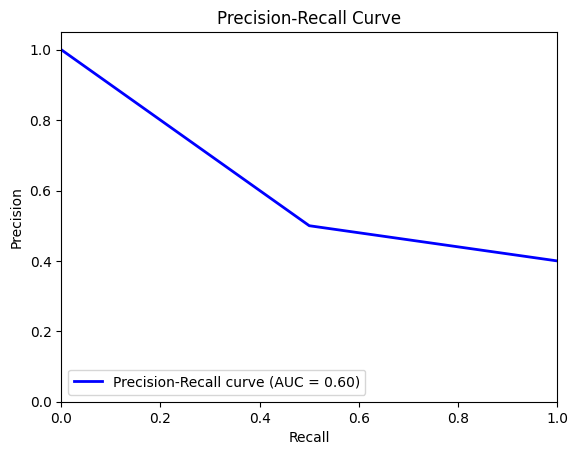

In [ ]:
plt.figure()
plt.plot(recall_3_5_turbo, precision_3_5_turbo, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

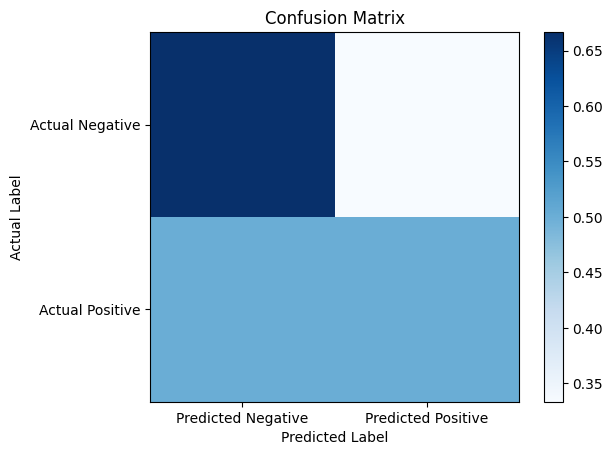

In [ ]:
plt.figure()
plt.imshow(conf_matrix_norm_3_5_turbo, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

#### For Benefit Redundancy

In [ ]:
ground_truth: np.array
predicted_redundancy: np.array
tp_3_5_turbo: int = 0
fp_3_5_turbo: int = 0
tn_3_5_turbo: int = 0
fn_3_5_turbo: int = 0

In [ ]:
ground_truth, predicted_redundancy, tp_3_5_turbo, fp_3_5_turbo, tn_3_5_turbo, fn_3_5_turbo = calc_benefit_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-3.5-turbo'])

In [ ]:
precision_3_5_turbo = precision_score(ground_truth, predicted_redundancy)
recall_3_5_turbo = recall_score(ground_truth, predicted_redundancy)
f1_3_5_turbo = f1_score(ground_truth, predicted_redundancy)
accuracy_3_5_turbo = accuracy_score(ground_truth, predicted_redundancy)

sensitivity_3_5_turbo = tp_3_5_turbo / (tp_3_5_turbo + fn_3_5_turbo) 
specificity_3_5_turbo = tn_3_5_turbo / (tn_3_5_turbo + fp_3_5_turbo)
fpr_manual_3_5_turbo = fp_3_5_turbo / (fp_3_5_turbo + tn_3_5_turbo)

#Confusion Matrix
conf_matrix_3_5_turbo = confusion_matrix(ground_truth, predicted_redundancy)
conf_matrix_norm_3_5_turbo = conf_matrix_3_5_turbo.astype('float') / conf_matrix_3_5_turbo.sum(axis=1)[:, np.newaxis]

###Check the following if I did it correctly
### Use maybe roc_auc_score
#ROC Curve and AUC-ROC
fpr_3_5_turbo, tpr_3_5_turbo, thresholds_3_5_turbo = roc_curve(ground_truth, predicted_redundancy)
roc_auc_3_5_turbo = auc(fpr_3_5_turbo, tpr_3_5_turbo)
# Precision-Recall Curve and AUC-PR
precision_3_5_turbo, recall_3_5_turbo, __3_5_turbo = precision_recall_curve(ground_truth, predicted_redundancy)
pr_auc = auc(recall_3_5_turbo, precision_3_5_turbo)


In [ ]:
print("Precision:", precision_3_5_turbo)
print("Recall:",recall_3_5_turbo)
print("F1:",f1_3_5_turbo)
print("Accuracy:",accuracy_3_5_turbo)
print("Sensitivity:",sensitivity_3_5_turbo)
print("Specificity:",specificity_3_5_turbo)
print("False positive rate:", fpr_manual_3_5_turbo)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_3_5_turbo)
print("Normalised Confusion Matrix:", conf_matrix_norm_3_5_turbo)
print("-" * 5)
print("AUC-ROC:", roc_auc_3_5_turbo)
print("AUC-PR:", pr_auc)

Precision: [0.4 0.5 1. ]
Recall: [1.  0.5 0. ]
F1: 0.5
Accuracy: 0.6
Sensitivity: 0.5
Specificity: 0.5
False positive rate: 0.5
-----
Confusion Matrix: [[2 1]
 [1 1]]
Normalised Confusion Matrix: [[0.66666667 0.33333333]
 [0.5        0.5       ]]
-----
AUC-ROC: 0.5833333333333334
AUC-PR: 0.6


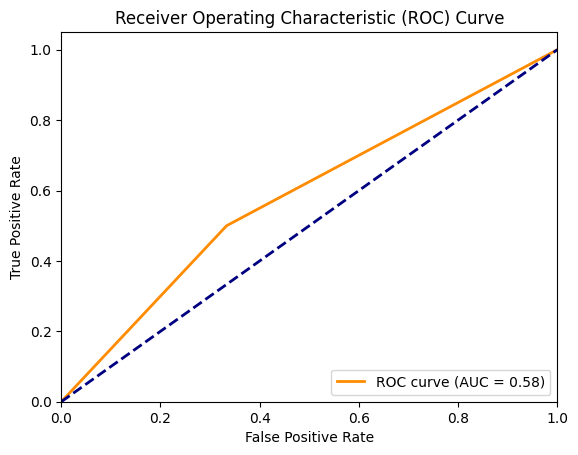

In [ ]:
plt.figure()
plt.plot(fpr_3_5_turbo, tpr_3_5_turbo, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

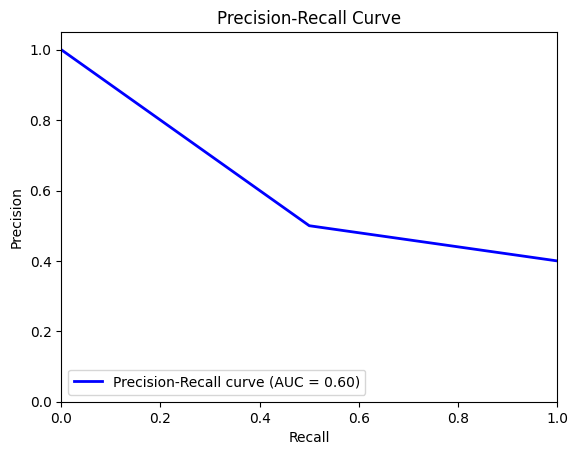

In [ ]:
plt.figure()
plt.plot(recall_3_5_turbo, precision_3_5_turbo, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

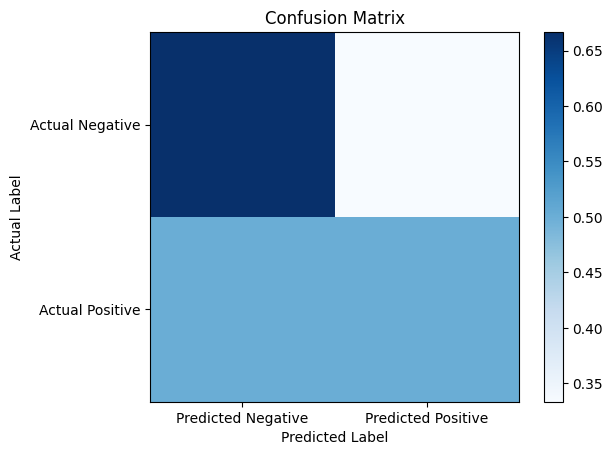

In [ ]:
plt.figure()
plt.imshow(conf_matrix_norm_3_5_turbo, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

#### redundancy-model-gpt-4-turbo

#### For Main Part Redundancy (Full/Partial?)

In [ ]:
ground_truth: np.array
predicted_redundancy: np.array
tp_4_turbo: int = 0
fp_4_turbo: int = 0
tn_4_turbo: int = 0
fn_4_turbo: int = 0

In [ ]:
ground_truth, predicted_redundancy, tp_4_turbo, fp_4_turbo, tn_4_turbo, fn_4_turbo = calc_main_part_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-4-turbo'])

In [ ]:
precision_4_turbo = precision_score(ground_truth, predicted_redundancy)
recall_4_turbo = recall_score(ground_truth, predicted_redundancy)
f1_4_turbo = f1_score(ground_truth, predicted_redundancy)
accuracy_4_turbo = accuracy_score(ground_truth, predicted_redundancy)

sensitivity_4_turbo = tp_4_turbo / (tp_4_turbo + fn_4_turbo) 
specificity_4_turbo = tn_4_turbo / (tn_4_turbo + fp_4_turbo)
fpr_manual_4_turbo = fp_4_turbo / (fp_3_5_turbo + tn_4_turbo)

#Confusion Matrix
conf_matrix_4_turbo = confusion_matrix(ground_truth, predicted_redundancy)
conf_matrix_norm_4_turbo = conf_matrix_4_turbo.astype('float') / conf_matrix_4_turbo.sum(axis=1)[:, np.newaxis]

###Check the following if I did it correctly
### Use maybe roc_auc_score
#ROC Curve and AUC-ROC
fpr_4_turbo, tpr_4_turbo, thresholds_4_turbo = roc_curve(ground_truth, predicted_redundancy)
roc_auc_4_turbo = auc(fpr_4_turbo, tpr_4_turbo)
# Precision-Recall Curve and AUC-PR
precision_4_turbo, recall_4_turbo, __4_turbo = precision_recall_curve(ground_truth, predicted_redundancy)
pr_auc = auc(recall_4_turbo, precision_4_turbo)


In [ ]:
print("Precision:", precision_4_turbo)
print("Recall:",recall_4_turbo)
print("F1:",f1_4_turbo)
print("Accuracy:",accuracy_4_turbo)
print("Sensitivity:",sensitivity_4_turbo)
print("Specificity:",specificity_4_turbo)
print("False positive rate:", fpr_manual_4_turbo)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_4_turbo)
print("Normalised Confusion Matrix:", conf_matrix_norm_4_turbo)
print("-" * 5)
print("AUC-ROC:", roc_auc_4_turbo)
print("AUC-PR:", pr_auc)

Precision: [0.4 0.5 1. ]
Recall: [1.  0.5 0. ]
F1: 0.5
Accuracy: 0.6
Sensitivity: 0.5
Specificity: 0.5
False positive rate: 0.5
-----
Confusion Matrix: [[2 1]
 [1 1]]
Normalised Confusion Matrix: [[0.66666667 0.33333333]
 [0.5        0.5       ]]
-----
AUC-ROC: 0.5833333333333334
AUC-PR: 0.6


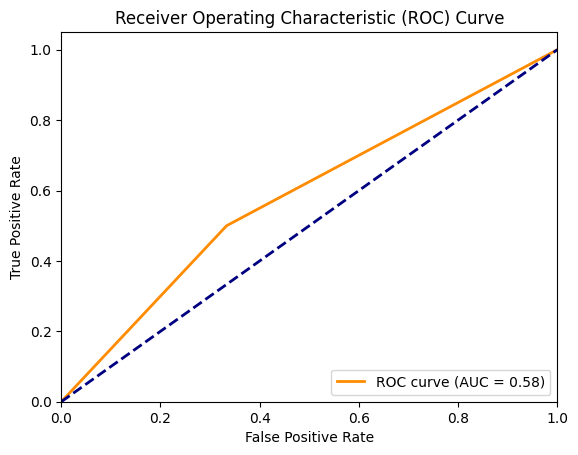

In [ ]:
plt.figure()
plt.plot(fpr_4_turbo, tpr_4_turbo, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

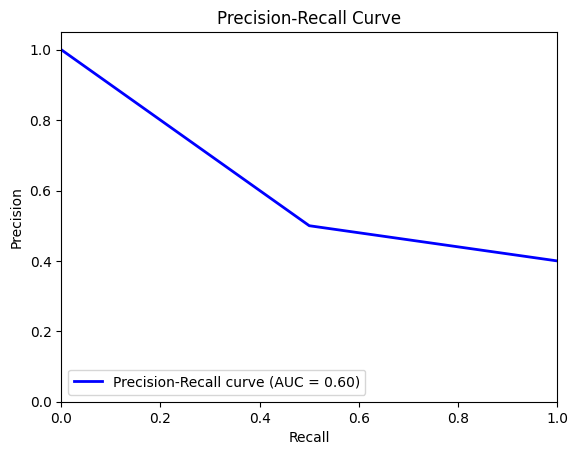

In [ ]:
plt.figure()
plt.plot(recall_3_5_turbo, precision_3_5_turbo, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

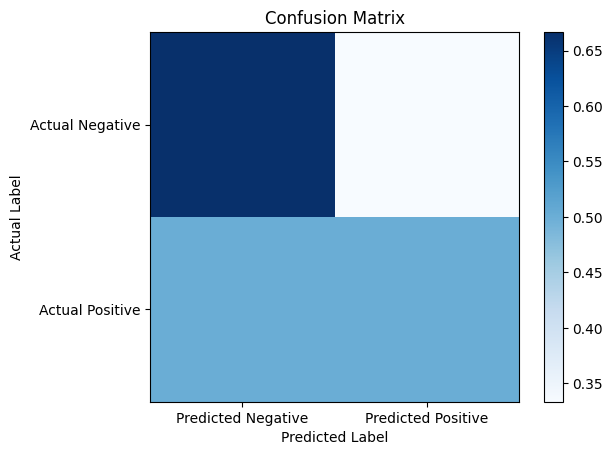

In [ ]:
plt.figure()
plt.imshow(conf_matrix_norm_3_5_turbo, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

#### For Benefit Redundancy (Full/Partial?)

In [ ]:
ground_truth: np.array
predicted_redundancy: np.array
tp_4_turbo: int = 0
fp_4_turbo: int = 0
tn_4_turbo: int = 0
fn_4_turbo: int = 0

In [ ]:
ground_truth, predicted_redundancy, tp_4_turbo, fp_4_turbo, tn_4_turbo, fn_4_turbo = calc_main_part_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-4-turbo'])

In [ ]:
precision_4_turbo = precision_score(ground_truth, predicted_redundancy)
recall_4_turbo = recall_score(ground_truth, predicted_redundancy)
f1_4_turbo = f1_score(ground_truth, predicted_redundancy)
accuracy_4_turbo = accuracy_score(ground_truth, predicted_redundancy)

sensitivity_4_turbo = tp_4_turbo / (tp_4_turbo + fn_4_turbo) 
specificity_4_turbo = tn_4_turbo / (tn_4_turbo + fp_4_turbo)
fpr_manual_4_turbo = fp_4_turbo / (fp_3_5_turbo + tn_4_turbo)

#Confusion Matrix
conf_matrix_4_turbo = confusion_matrix(ground_truth, predicted_redundancy)
conf_matrix_norm_4_turbo = conf_matrix_4_turbo.astype('float') / conf_matrix_4_turbo.sum(axis=1)[:, np.newaxis]

###Check the following if I did it correctly
### Use maybe roc_auc_score
#ROC Curve and AUC-ROC
fpr_4_turbo, tpr_4_turbo, thresholds_4_turbo = roc_curve(ground_truth, predicted_redundancy)
roc_auc_4_turbo = auc(fpr_4_turbo, tpr_4_turbo)
# Precision-Recall Curve and AUC-PR
precision_4_turbo, recall_4_turbo, __4_turbo = precision_recall_curve(ground_truth, predicted_redundancy)
pr_auc = auc(recall_4_turbo, precision_4_turbo)

In [ ]:
print("Precision:", precision_4_turbo)
print("Recall:",recall_4_turbo)
print("F1:",f1_4_turbo)
print("Accuracy:",accuracy_4_turbo)
print("Sensitivity:",sensitivity_4_turbo)
print("Specificity:",specificity_4_turbo)
print("False positive rate:", fpr_manual_4_turbo)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_4_turbo)
print("Normalised Confusion Matrix:", conf_matrix_norm_4_turbo)
print("-" * 5)
print("AUC-ROC:", roc_auc_4_turbo)
print("AUC-PR:", pr_auc)

Precision: [0.4 0.5 1. ]
Recall: [1.  0.5 0. ]
F1: 0.5
Accuracy: 0.6
Sensitivity: 0.5
Specificity: 0.5
False positive rate: 0.5
-----
Confusion Matrix: [[2 1]
 [1 1]]
Normalised Confusion Matrix: [[0.66666667 0.33333333]
 [0.5        0.5       ]]
-----
AUC-ROC: 0.5833333333333334
AUC-PR: 0.6


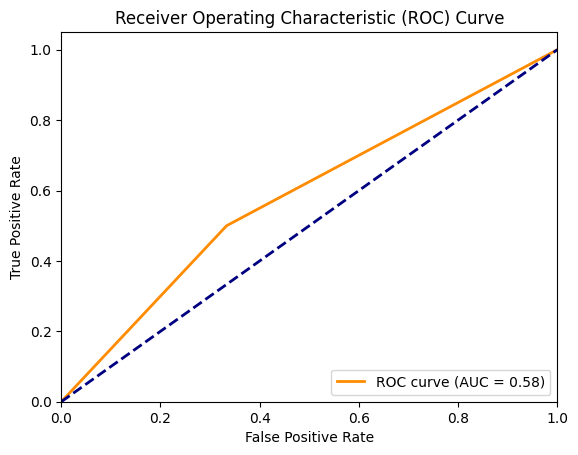

In [ ]:
plt.figure()
plt.plot(fpr_4_turbo, tpr_4_turbo, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

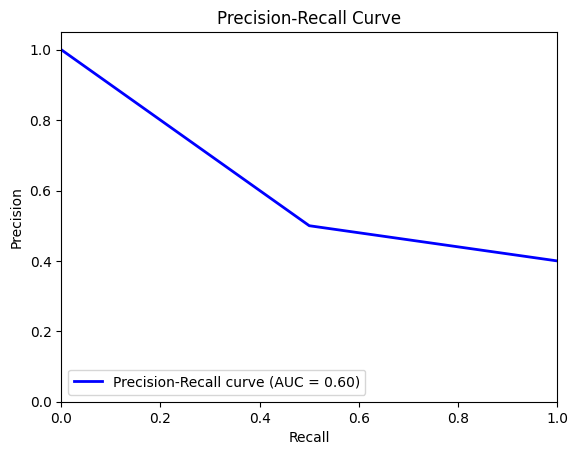

In [ ]:
plt.figure()
plt.plot(recall_4_turbo, precision_4_turbo, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

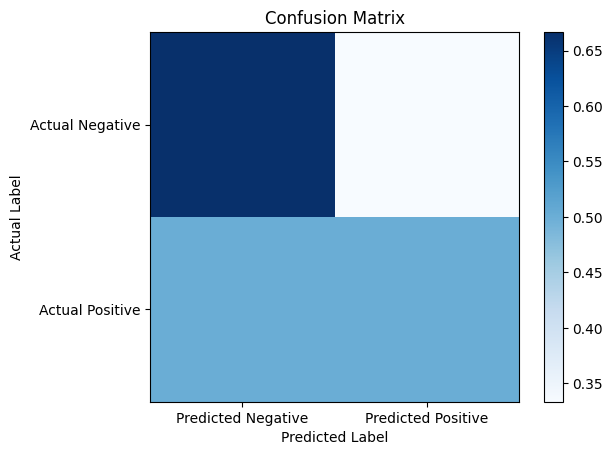

In [ ]:
plt.figure()
plt.imshow(conf_matrix_norm_4_turbo, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

##

In [46]:
REDUNDANCY_CATEGORIES_FALSE_TYPE = ["False Positive", "False Negative"]
REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT = ["Main Part", "Benefit"]


DF_SHOW_FALSE_POSITIVES_NEGATIVES_DTYPES = {
    'Execution Run': 'int',
    'Model': 'str',
    'False Type': pd.CategoricalDtype(categories=REDUNDANCY_CATEGORIES_FALSE_TYPE),
    'Main Part or Benefit': pd.CategoricalDtype(categories=REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT),
    'User Story Id 1': 'int',
    'User Story Id 2': 'int',
    'Reason from ChatGPT': 'str',
    'Refered Text 1 by ChatGPT': 'str',
    'Refered Text 1 from formal Approach': 'str',
    'Refered Text 2 by ChatGPT': 'str',
    'Refered Text 2 from formal Approach': 'str'
}
df_show_false_positives_negatives = pd.DataFrame(columns=DF_SHOW_FALSE_POSITIVES_NEGATIVES_DTYPES.keys()).astype(dtype=DF_SHOW_FALSE_POSITIVES_NEGATIVES_DTYPES)

In [52]:
def fill_df_show_false_positives_negatives(local_df_show_false_positives_negatives: pd.core.series.Series, model: str, chat_gpt_input_category: dict) -> pd.DataFrame:
    CATEGORY_FALSE_POSITIVE = "False Positive"
    CATEGORY_FALSE_NEGATIVE = "False Negative"
    CATEGORY_MAIN_PART = "Main Part"
    CATEGORY_BENEFIT = "Benefit"
    
    def add_row_to_show_false_positives(local_df_show_false_positives_negatives: pd.DataFrame, execution_run: int, model: str, false_type: str, main_or_benefit: str, usid_one: int, 
                                    usid_two: int, reason_chat: str, text_chat_one: str, text_chat_two: str, text_formal_one: str, text_formal_two: str) -> pd.DataFrame:
        new_row = pd.DataFrame({
            'Execution Run':[execution_run],
            'Model': [model],
            'False Type': pd.Categorical([false_type], categories=REDUNDANCY_CATEGORIES_FALSE_TYPE),
            'Main Part or Benefit': pd.Categorical([main_or_benefit], categories=REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT),
            'User Story Id 1': [usid_one],
            'User Story Id 2': [usid_two],
            'Reason from ChatGPT': [reason_chat],
            'Refered Text 1 by ChatGPT': [text_chat_one],
            'Refered Text 1 from formal Approach': [text_formal_one],
            'Refered Text 2 by ChatGPT': [text_chat_two],
            'Refered Text 2 from formal Approach': [text_formal_two]
        })
        return pd.concat([local_df_show_false_positives_negatives, new_row], ignore_index=True)
    
    def split_and_remove_prefix(snippet: pd.DataFrame) -> tuple[int, int]:
        PATTERN = r'^user_story_\d+: #\w+#'
        formal_text_one, formal_text_two = (snippet.iloc[0]['User Stories Texts']).split("\n\n")
        formal_text_one = re.sub(PATTERN, '', formal_text_one)
        formal_text_two = re.sub(PATTERN, '', formal_text_two)
        return formal_text_one, formal_text_two
    
    def collecting_reasons_and_references(items: list) -> tuple[str, str, str]:
        reason_describtions:str = ""
        reference_to_original_text_one:str  = ""
        reference_to_original_text_two:str = ""
        for idx, item in enumerate(items):
            reason_describtions += f'{idx}.) {item['reasonDescribtion']}\n'
            reference_to_original_text_one += f'{idx}.) {item['referenceToOriginalText'][0]}\n\n'
            reference_to_original_text_two += f'{idx}.) {item['referenceToOriginalText'][1]}\n\n'
        return reason_describtions, reference_to_original_text_one, reference_to_original_text_two
    
    for file in chat_gpt_input_category.values():
        file_content = file
        for item in file_content:
            filtered_rows = excel_data[(excel_data['Corresponding USID 1'].astype(int) == int(item['relatedStories'][0])) 
                                        & (excel_data['Corresponding USID 2'].astype(int) == int(item['relatedStories'][1]))]
            if (filtered_rows.shape[0] == 1):
                formal_text_one, formal_text_two = split_and_remove_prefix(filtered_rows)
                reason_describtions_main_part, reference_to_original_text_one_main_part, reference_to_original_text_two_main_part = collecting_reasons_and_references(item['mainPartRedundancies'])
                reason_describtions_benefit, reference_to_original_text_one_benefit, reference_to_original_text_two_benefit = collecting_reasons_and_references(item['benefitRedundancies'])
                usidone: int = int(item['relatedStories'][0])
                usidtwo: int = int(item['relatedStories'][1])
                run: int = chat_gpt_input_category.keys()[0].split("_")[0]
                
                #Searching for the false positives and false negatives thus the reveresed case is also check
                if bool(item['redundantMainPart']) and not bool(excel_data.iat[0, 6]):
                    local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, item,
                                                                                               model, CATEGORY_FALSE_POSITIVE, 
                                                                                               CATEGORY_MAIN_PART, usidone, usidtwo,
                                                                                               reason_describtions_main_part,
                                                                                               reference_to_original_text_one_main_part, 
                                                                                               reference_to_original_text_two_main_part, 
                                                                                               formal_text_one,
                                                                                               formal_text_two)
                elif not bool(item['redundantMainPart']) and bool(excel_data.iat[0, 6]):
                    local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, item,
                                                                                               model, CATEGORY_FALSE_NEGATIVE, 
                                                                                               CATEGORY_MAIN_PART, usidone, usidtwo,
                                                                                               reason_describtions_main_part,
                                                                                               reference_to_original_text_one_main_part, 
                                                                                               reference_to_original_text_two_main_part, 
                                                                                               formal_text_one,
                                                                                               formal_text_two)
                if bool(item['redundantBenefit']) and not bool(excel_data.iat[0, 7]):
                    local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, item,
                                                                                               model, CATEGORY_FALSE_POSITIVE, 
                                                                                               CATEGORY_BENEFIT, usidone, usidtwo,
                                                                                               reason_describtions_benefit,
                                                                                               reference_to_original_text_one_benefit, 
                                                                                               reference_to_original_text_two_benefit, 
                                                                                               formal_text_one,
                                                                                               formal_text_two)
                if not bool(item['redundantBenefit']) and bool(excel_data.iat[0, 7]):
                    local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, item,
                                                                                               model, CATEGORY_FALSE_NEGATIVE, 
                                                                                               CATEGORY_BENEFIT, usidone, usidtwo,
                                                                                               reason_describtions_benefit,
                                                                                               reference_to_original_text_one_benefit, 
                                                                                               reference_to_original_text_two_benefit, 
                                                                                               formal_text_one,
                                                                                               formal_text_two)
            elif (filtered_rows.shape[0] >= 2):
                raise Exception("There are more than or equal to 2 filtered rows.\n" + f"JSON File: {item}\n" + f"Excel{filtered_rows}")
    return local_df_show_false_positives_negatives

In [54]:
show_false_positives = chat_gpt_results['redundancy-model-gpt-3.5-turbo']
df_show_false_positives_negatives = fill_df_show_false_positives_negatives(df_show_false_positives_negatives, 'gpt-3.5-turbo', show_false_positives)
df_show_false_positives_negatives.head(2)

UnboundLocalError: cannot access local variable 'local_df_show_false_positives_negatives' where it is not associated with a value